In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import argparse

import tensorflow as tf

import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys; sys.path.append('../')
import seq2seq_abstracter_models
import utils

2023-02-15 20:24:40.413158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 20:24:40.590575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vast/palmer/apps/avx.grace/software/Code-Server/4.7.0/lib:/gpfs/loomis/apps/avx/software/Perl/5.32.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/DB/18.1.40-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libreadline/8.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/gettext/0.21-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/ncurses/6.2-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libxml

In [2]:
tf.config.list_physical_devices()

2023-02-15 20:24:43.048334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vast/palmer/apps/avx.grace/software/Code-Server/4.7.0/lib:/gpfs/loomis/apps/avx/software/Perl/5.32.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/DB/18.1.40-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libreadline/8.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/gettext/0.21-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/ncurses/6.2-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/XZ/5.2.5-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/expat/2.2.9-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/cURL/7.72.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/zlib/1.2.11-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/GCCcore/10.2.0/lib64:/gpfs/loomis/apps

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

0.2.0/lib64:/gpfs/loomis/apps/avx/software/GCCcore/10.2.0/lib
2023-02-15 20:24:43.052874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vast/palmer/apps/avx.grace/software/Code-Server/4.7.0/lib:/gpfs/loomis/apps/avx/software/Perl/5.32.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/DB/18.1.40-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libreadline/8.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/gettext/0.21-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/ncurses/6.2-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/XZ/5.2.5-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/expat/2.2.9-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/cURL/7.72.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/zlib/1.2.11-GCCcore-10.2.0/lib:/gpfs/l

In [3]:
import wandb
wandb.login()

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

wandb_project_name = None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


In [4]:
def create_callbacks(monitor='loss'):
    callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

from seq2seq_transformer import masked_loss, masked_accuracy

metrics = [masked_accuracy]

loss = masked_loss
create_opt = lambda : tf.keras.optimizers.Adam()

fit_kwargs = {'epochs': 20, 'batch_size': 128}


## Dataset

In [5]:
def create_sorting_dataset(vocab_size, dim, seqs_length, n_seqs):

    # generate random features for each object
    objects = np.random.normal(size=(vocab_size, dim))

    # generate random permutations of length `seqs_length` out of `vocab_size`
    seqs = np.array([np.random.choice(range(vocab_size), size=seqs_length, replace=False) for _ in range(n_seqs)])
    
    # remove duplicate seqs (although very unlikely)
    _, unique_seq_idxs = np.unique(seqs, axis=0, return_inverse=True)
    seqs = seqs[unique_seq_idxs]

    # create object sequences
    object_seqs = objects[seqs]
    
    sorted_seqs = np.sort(seqs, axis=1)

    arg_sort = np.argsort(seqs, axis=1)

    
    # add `START_TOKEN` to beginning of sorting 
    START_TOKEN = seqs_length
    start_tokens = np.array([START_TOKEN] * len(arg_sort))[np.newaxis].T
    arg_sort = np.hstack([start_tokens, arg_sort])

    return objects, seqs, sorted_seqs, arg_sort, object_seqs,

In [6]:
vocab_size = 32
dim = 8
seqs_length = 7
START_TOKEN = seqs_length
n_seqs = 10_0000

objects, seqs, sorted_seqs, arg_sort, object_seqs = create_sorting_dataset(vocab_size, dim, seqs_length, n_seqs)

target = arg_sort[:, :-1]
labels = arg_sort[:, 1:]

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size))

In [16]:
def evaluate_seq2seq_model(model, source_test, target_test, labels_test, start_token=START_TOKEN, print_=False):
    
    n = len(source_test)
    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = start_token
    for i in range(seqs_length):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    per_card_acc = (np.mean(output[:,1:] == labels_test))
    acc_per_position = [np.mean(output[:, i+1] == labels_test[:, i]) for i in range(seqs_length)]
    seq_acc = np.mean(np.all(output[:,1:]==labels_test, axis=1))
    masked_acc = masked_accuracy(labels_test, model([source_test, target_test]))

    if print_:
        print('per-card accuracy: %.2f%%' % (100*per_card_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))
        print('masked_accuracy (teacher-forcing):  %.2f%%' % (100*masked_acc))


    return_dict = {
        'per-card accuracy': per_card_acc, 'full sequence accuracy': seq_acc,
        'masked_accuracy': masked_acc, 'acc_by_position': acc_per_position
        }

    return return_dict

def log_to_wandb(model, evaluation_dict):
    acc_by_position_table = wandb.Table(
        data=[(i, acc) for i, acc in enumerate(evaluation_dict['acc_by_position'])], 
        columns=["position", "per-card accuracy at position"])

    evaluation_dict['acc_by_position'] = wandb.plot.line(
        acc_by_position_table, "position", "per-card accuracy at position",
        title="Per-Card Accuracy By Position")

    wandb.log(evaluation_dict)

## Transformer with $\text{Output} \sim E D^\top$

$E \in \mathbb{R}^{n \times d}, D \in \mathbb{R}^{n \times d} \implies E D^\top \in \mathbb{R}^{n \times n}$. $(ED^\top)_{ij} = \sum_{k}{E_{ik} D_{jk}} = \langle E_i, D_j \rangle$

In [8]:
from tensorflow.keras import layers
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder


class ArgsortTransformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        # self.embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.source_token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='token_embedder')
        # self.target_token_embedder = self.source_token_embedder
        self.target_token_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')

        # self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.source_token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.target_token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        # logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        logits = tf.linalg.matmul(encoder_context, tf.transpose(x, perm=(0,2,1)))
        logits = tf.transpose(logits, perm=(0,2,1))

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [9]:
argsort_transformer = ArgsortTransformer(
    num_layers=2, num_heads=2, dff=64, 
    # input_vocab_size=vocab_size+1, target_vocab_size=vocab_size+1, embedding_dim=128)
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

argsort_transformer.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_transformer((seqs_train[:32], target_train[:32]));

argsort_transformer.summary()

2023-02-15 20:25:19.519763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_embedder (Embedding)  multiple                  2048      
                                                                 
 target_embedder (Embedding)  multiple                 512       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 decoder (ContextDecoder)    multiple                  

In [10]:
train_size = 5000 # len(seqs_train)
X_train = seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = seqs_val, target_val
y_val = labels_val

history = argsort_transformer.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, **fit_kwargs) # callbacks=create_callbacks()

Epoch 1/20
40/40 [==============================] - 9s 81ms/step - loss: 2.3692 - masked_accuracy: 0.1808 - val_loss: 1.8285 - val_masked_accuracy: 0.2704
Epoch 2/20
40/40 [==============================] - 2s 55ms/step - loss: 1.6858 - masked_accuracy: 0.2908 - val_loss: 1.0750 - val_masked_accuracy: 0.5540
Epoch 3/20
40/40 [==============================] - 2s 55ms/step - loss: 0.9784 - masked_accuracy: 0.5787 - val_loss: 0.4860 - val_masked_accuracy: 0.8008
Epoch 4/20
40/40 [==============================] - 2s 55ms/step - loss: 0.5120 - masked_accuracy: 0.7846 - val_loss: 0.2859 - val_masked_accuracy: 0.8830
Epoch 5/20
40/40 [==============================] - 2s 55ms/step - loss: 0.3554 - masked_accuracy: 0.8590 - val_loss: 0.1065 - val_masked_accuracy: 0.9760
Epoch 6/20
40/40 [==============================] - 2s 54ms/step - loss: 0.2539 - masked_accuracy: 0.8999 - val_loss: 0.0756 - val_masked_accuracy: 0.9855
Epoch 7/20
40/40 [==============================] - 2s 55ms/step - los

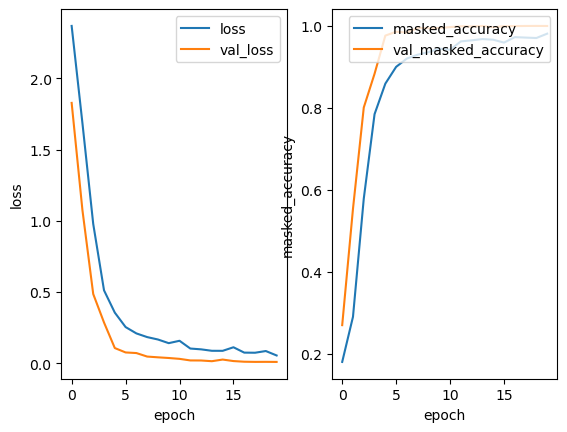

In [11]:
utils.plot_history(history, ('loss', 'masked_accuracy'));

In [12]:
eval_dict = evaluate_seq2seq_model(argsort_transformer, seqs_train, target_train, labels_train, print_=True)

per-card accuracy: 97.99%
full sequence accuracy: 86.91%
masked_accuracy (teacher-forcing):  99.94%


In [14]:
eval_dict = evaluate_seq2seq_model(argsort_transformer, seqs_test, target_test, labels_test, print_=True)

per-card accuracy: 98.00%
full sequence accuracy: 87.02%
masked_accuracy (teacher-forcing):  99.94%


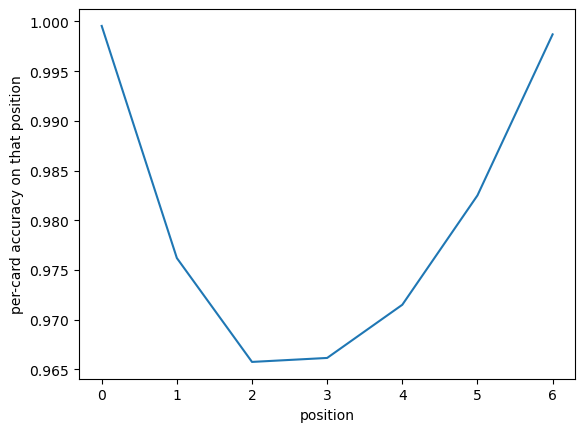

In [15]:
acc_per_position = eval_dict['acc_by_position']
plt.plot(acc_per_position);
plt.xlabel('position');
plt.ylabel('per-card accuracy on that position');

## Transformer with Random Embedding Inputs and $\text{Output} \sim E D^\top$

In [17]:
from tensorflow.keras import layers
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder


class ArgsortTransformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        # self.source_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='token_embedder')
        self.target_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')

        # self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.target_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        # logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        logits = tf.linalg.matmul(encoder_context, tf.transpose(x, perm=(0,2,1)))
        logits = tf.transpose(logits, perm=(0,2,1))

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [18]:
argsort_transformer = ArgsortTransformer(
    num_layers=2, num_heads=2, dff=64, 
    # input_vocab_size=vocab_size+1, target_vocab_size=vocab_size+1, embedding_dim=128)
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

argsort_transformer.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_transformer((object_seqs_train[:32], target_train[:32]));

argsort_transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 512       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                       

In [19]:
# TODO: this seems to be helping! train on larger dataset and see results

train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = object_seqs_val, target_val
y_val = labels_val

history = argsort_transformer.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, **fit_kwargs) # callbacks=create_callbacks()

Epoch 1/20
40/40 [==============================] - 8s 79ms/step - loss: 3.2313 - masked_accuracy: 0.1713 - val_loss: 1.8316 - val_masked_accuracy: 0.2532
Epoch 2/20
40/40 [==============================] - 2s 52ms/step - loss: 1.8741 - masked_accuracy: 0.2218 - val_loss: 1.7476 - val_masked_accuracy: 0.2723
Epoch 3/20
40/40 [==============================] - 2s 53ms/step - loss: 1.7903 - masked_accuracy: 0.2545 - val_loss: 1.6698 - val_masked_accuracy: 0.2966
Epoch 4/20
40/40 [==============================] - 2s 54ms/step - loss: 1.6912 - masked_accuracy: 0.3012 - val_loss: 1.5078 - val_masked_accuracy: 0.3828
Epoch 5/20
40/40 [==============================] - 2s 54ms/step - loss: 1.5506 - masked_accuracy: 0.3577 - val_loss: 1.2891 - val_masked_accuracy: 0.4679
Epoch 6/20
40/40 [==============================] - 2s 54ms/step - loss: 1.3657 - masked_accuracy: 0.4327 - val_loss: 1.0668 - val_masked_accuracy: 0.5393
Epoch 7/20
40/40 [==============================] - 2s 55ms/step - los

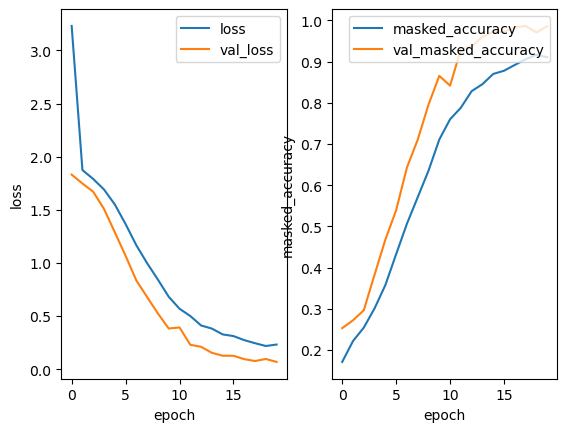

In [20]:
utils.plot_history(history, ('loss', 'masked_accuracy'));

In [21]:
eval_dict = evaluate_seq2seq_model(argsort_transformer, object_seqs_train, target_train, labels_train, print_=True)

per-card accuracy: 98.46%
full sequence accuracy: 91.14%
masked_accuracy (teacher-forcing):  98.70%


In [23]:
eval_dict = evaluate_seq2seq_model(argsort_transformer, object_seqs_test, target_test, labels_test, print_=True)

per-card accuracy: 98.54%
full sequence accuracy: 91.46%
masked_accuracy (teacher-forcing):  98.75%


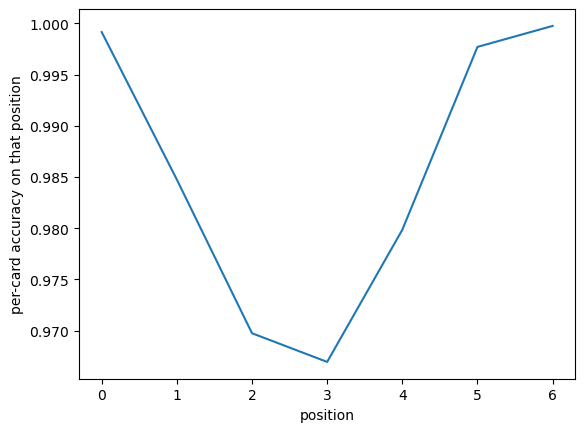

In [24]:
acc_per_position = eval_dict['acc_by_position']
plt.plot(acc_per_position);
plt.xlabel('position');
plt.ylabel('per-card accuracy on that position');

## Seq2Seq Sensory-Connected Abstracter with $\text{Output} \sim E D^\top$

In [25]:
from tensorflow.keras import layers
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder
from abstracters import RelationalAbstracter

class ArgsortSeq2SeqSensoryConnectedAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_sensory_connected_abstracter'):
        super().__init__(name=name)

        self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.target_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')


        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')

        # self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.target_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=abstracted_context, key_seq=abstracted_context, value_seq=encoder_context)

        # Final linear layer output.
        # logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        logits = tf.linalg.matmul(encoder_context, tf.transpose(x, perm=(0,2,1)))
        logits = tf.transpose(logits, perm=(0,2,1))

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits


In [26]:
argsort_model = ArgsortSeq2SeqSensoryConnectedAbstracter(
    num_layers=2, num_heads=2, dff=64, 
    # input_vocab_size=vocab_size+1, target_vocab_size=vocab_size+1, embedding_dim=128)
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

Model: "seq2seq_sensory_connected_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 512       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                              

In [27]:
# TODO: this seems to be helping! train on larger dataset and see results

train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = object_seqs_val, target_val
y_val = labels_val

history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, **fit_kwargs) # callbacks=create_callbacks()

Epoch 1/20
40/40 [==============================] - 13s 124ms/step - loss: 3.4607 - masked_accuracy: 0.1995 - val_loss: 1.7441 - val_masked_accuracy: 0.2950
Epoch 2/20
40/40 [==============================] - 3s 87ms/step - loss: 1.8380 - masked_accuracy: 0.2506 - val_loss: 1.6364 - val_masked_accuracy: 0.3449
Epoch 3/20
40/40 [==============================] - 3s 86ms/step - loss: 1.6762 - masked_accuracy: 0.3148 - val_loss: 1.4040 - val_masked_accuracy: 0.4139
Epoch 4/20
40/40 [==============================] - 3s 86ms/step - loss: 1.4675 - masked_accuracy: 0.3896 - val_loss: 1.1263 - val_masked_accuracy: 0.5159
Epoch 5/20
40/40 [==============================] - 3s 86ms/step - loss: 1.2392 - masked_accuracy: 0.4728 - val_loss: 1.0070 - val_masked_accuracy: 0.5339
Epoch 6/20
40/40 [==============================] - 3s 86ms/step - loss: 1.0499 - masked_accuracy: 0.5454 - val_loss: 0.6484 - val_masked_accuracy: 0.7391
Epoch 7/20
40/40 [==============================] - 3s 86ms/step - l

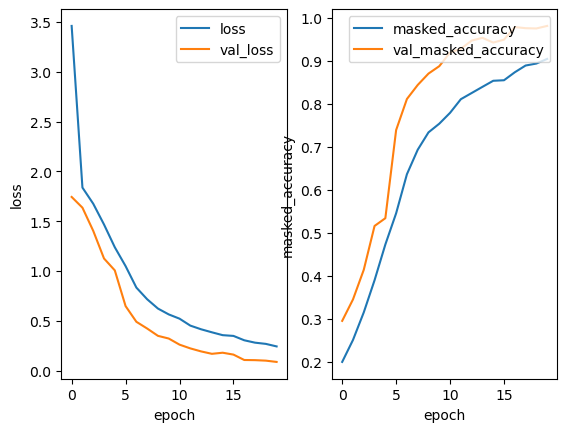

In [28]:
utils.plot_history(history, ('loss', 'masked_accuracy'));

In [29]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, print_=True)

per-card accuracy: 97.75%
full sequence accuracy: 86.32%
masked_accuracy (teacher-forcing):  98.18%


In [30]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, print_=True)

per-card accuracy: 97.76%
full sequence accuracy: 86.31%
masked_accuracy (teacher-forcing):  98.19%


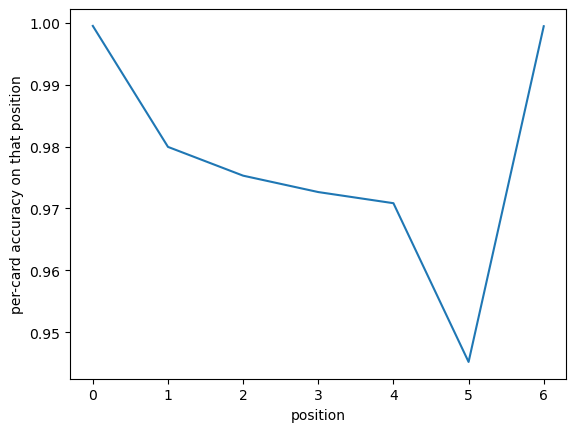

In [32]:
acc_per_position = eval_dict['acc_by_position']
plt.plot(acc_per_position);
plt.xlabel('position');
plt.ylabel('per-card accuracy on that position');

## Transformer on Labels / Target = $\text{argsort}$; Dense Final Layer

In [33]:
from tensorflow.keras import layers
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        # self.embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.source_token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='token_embedder')
        # self.target_token_embedder = self.source_token_embedder
        self.target_token_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')

        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.source_token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.target_token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [34]:
transformer = Transformer(
    num_layers=2, num_heads=2, dff=64, 
    # input_vocab_size=vocab_size+1, target_vocab_size=vocab_size+1, embedding_dim=128)
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

transformer.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
transformer((seqs_train[:32], target_train[:32]));

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_embedder (Embedding)  multiple                  2048      
                                                                 
 target_embedder (Embedding)  multiple                 512       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 decoder (ContextDecoder)    multiple                  

In [35]:
train_size = 1000 # len(seqs_train)
X_train = seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = seqs_val, target_val
y_val = labels_val

history = transformer.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, **fit_kwargs) # callbacks=create_callbacks()

Epoch 1/20
8/8 [==============================] - 7s 318ms/step - loss: 2.0835 - masked_accuracy: 0.1682 - val_loss: 1.7907 - val_masked_accuracy: 0.1953
Epoch 2/20
8/8 [==============================] - 1s 165ms/step - loss: 1.7925 - masked_accuracy: 0.1977 - val_loss: 1.7495 - val_masked_accuracy: 0.2141
Epoch 3/20
8/8 [==============================] - 1s 162ms/step - loss: 1.7624 - masked_accuracy: 0.2118 - val_loss: 1.7314 - val_masked_accuracy: 0.2502
Epoch 4/20
8/8 [==============================] - 1s 163ms/step - loss: 1.7222 - masked_accuracy: 0.2343 - val_loss: 1.6740 - val_masked_accuracy: 0.2977
Epoch 5/20
8/8 [==============================] - 1s 165ms/step - loss: 1.6626 - masked_accuracy: 0.2663 - val_loss: 1.5495 - val_masked_accuracy: 0.3126
Epoch 6/20
8/8 [==============================] - 1s 164ms/step - loss: 1.5717 - masked_accuracy: 0.3126 - val_loss: 1.4565 - val_masked_accuracy: 0.3462
Epoch 7/20
8/8 [==============================] - 1s 161ms/step - loss: 1.48

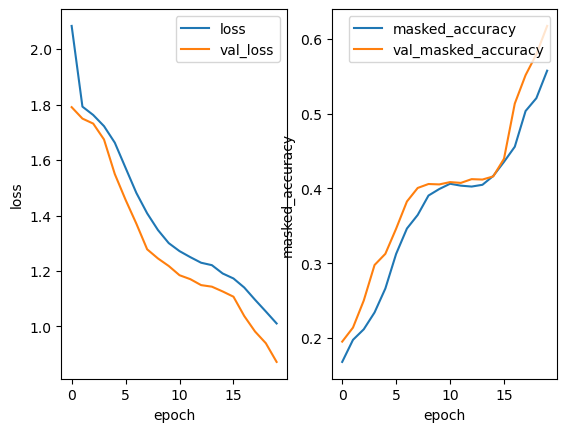

In [36]:
utils.plot_history(history, ('loss', 'masked_accuracy'));

In [37]:
eval_dict = evaluate_seq2seq_model(transformer, seqs_train, target_train, labels_train, print_=True)

per-card accuracy: 20.27%
full sequence accuracy: 0.00%
masked_accuracy (teacher-forcing):  61.92%


In [38]:
eval_dict = evaluate_seq2seq_model(transformer, seqs_test, target_test, labels_test, print_=True)

per-card accuracy: 20.48%
full sequence accuracy: 0.00%
masked_accuracy (teacher-forcing):  61.82%


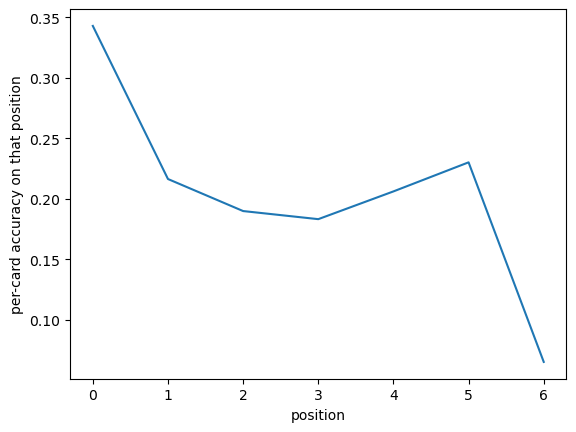

In [41]:
acc_per_position = eval_dict['acc_by_position']
plt.plot(acc_per_position);
plt.xlabel('position');
plt.ylabel('per-card accuracy on that position');

## Argsort with Relational Abstracter; Dense Final Layer 

In [42]:
from abstracters import RelationalAbstracter

class Seq2SeqSensoryConnectedAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_sensory_connected_abstracter'):
        super().__init__(name=name)

        
        # self.embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.source_token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='token_embedder')
        # self.target_token_embedder = self.source_token_embedder
        self.target_token_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
          
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.source_token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.target_token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=abstracted_context, key_seq=abstracted_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits


In [43]:
seq2seq_abstracter = Seq2SeqSensoryConnectedAbstracter(
    num_layers=2, num_heads=2, dff=64, 
    # input_vocab_size=vocab_size+1, target_vocab_size=vocab_size+1, embedding_dim=128)
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

seq2seq_abstracter.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
seq2seq_abstracter((seqs_train[:32], target_train[:32]));

seq2seq_abstracter.summary()

Model: "seq2seq_sensory_connected_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_embedder (Embedding)  multiple                  2048      
                                                                 
 target_embedder (Embedding)  multiple                 512       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 abstracter (RelationalAbstr  

In [44]:
train_size = 1000 # len(seqs_train)
X_train = seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = seqs_val, target_val
y_val = labels_val

history = seq2seq_abstracter.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, **fit_kwargs) # callbacks=create_callbacks()

Epoch 1/20
8/8 [==============================] - 11s 484ms/step - loss: 2.0132 - masked_accuracy: 0.1768 - val_loss: 1.8097 - val_masked_accuracy: 0.1877
Epoch 2/20
8/8 [==============================] - 2s 267ms/step - loss: 1.8119 - masked_accuracy: 0.1878 - val_loss: 1.7633 - val_masked_accuracy: 0.2048
Epoch 3/20
8/8 [==============================] - 2s 263ms/step - loss: 1.7820 - masked_accuracy: 0.2007 - val_loss: 1.7405 - val_masked_accuracy: 0.2313
Epoch 4/20
8/8 [==============================] - 2s 263ms/step - loss: 1.7434 - masked_accuracy: 0.2213 - val_loss: 1.6870 - val_masked_accuracy: 0.2650
Epoch 5/20
8/8 [==============================] - 2s 263ms/step - loss: 1.6734 - masked_accuracy: 0.2650 - val_loss: 1.5701 - val_masked_accuracy: 0.2934
Epoch 6/20
8/8 [==============================] - 2s 265ms/step - loss: 1.5975 - masked_accuracy: 0.3041 - val_loss: 1.4739 - val_masked_accuracy: 0.3289
Epoch 7/20
8/8 [==============================] - 2s 264ms/step - loss: 1.5

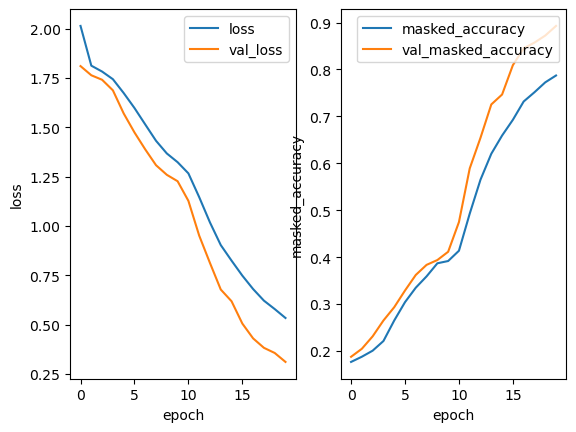

In [45]:
utils.plot_history(history, ('loss', 'masked_accuracy'));

In [46]:
eval_dict = evaluate_seq2seq_model(seq2seq_abstracter, seqs_train, target_train, labels_train, print_=True)

per-card accuracy: 39.96%
full sequence accuracy: 0.00%
masked_accuracy (teacher-forcing):  89.59%


In [47]:
eval_dict = evaluate_seq2seq_model(seq2seq_abstracter, seqs_test, target_test, labels_test, print_=True)

per-card accuracy: 39.87%
full sequence accuracy: 0.00%
masked_accuracy (teacher-forcing):  89.64%


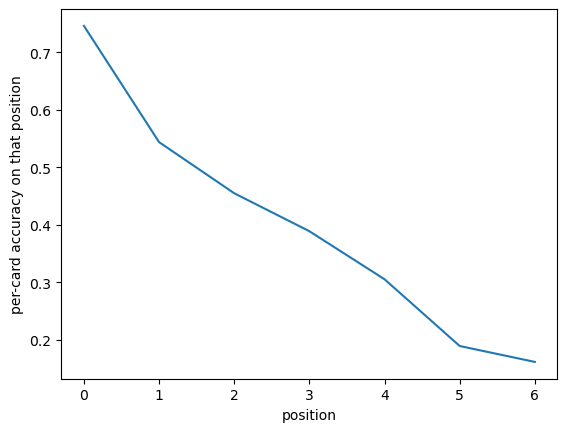

In [48]:
acc_per_position = eval_dict['acc_by_position']
plt.plot(acc_per_position);
plt.xlabel('position');
plt.ylabel('per-card accuracy on that position');